# Figure 2
## Spatial patterns of seasonal HIPE regimes and total number of unique daily HIPEs (i.e., non-concatenated) across the Alps, 1961–2022. 

In [13]:
## ---- Libraries and custom functions --------------------------------------
library(tidyverse)
library(cptcity)
'%!in%' <- function(x,y)!('%in%'(x,y))
library(terra)
library(tidyterra)
library(metR)
library(sf)
library(ggprism)
library(elevatr)
library(patchwork)
library(scales)
library(ggnewscale)
setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")
source("Script/Functions/Ranking_functions.R")
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

In [8]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# Alpine extent
sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [10]:
# Load ranking ACPD-HIPEs --------------------------------------------------
ACPD_HIPE <- read_csv("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022_multiday.csv") %>%
  mutate(dataset = "ACPD",
         id = 1:nrow(.)) 

# Spatial Visualizations -------------------------------------------------------

# Threshold for detecting HIPEs
ACPD_HIPE_grid_thr <- readr::read_rds("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_threshold_nevents_1961-2022_gridded.rds")

# !!!Single-day!!! HIPE gridded events
ACPD_HIPE_grid <- readr::read_rds("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022_gridded.rds")

# Calculating daily excedences (using the single day extreme db as we used daily thresholds)
epe_db_grid_events_P_H <- ACPD_HIPE_grid %>%
  inner_join(ACPD_HIPE_grid_thr, by = c("lon","lat")) %>%
  group_by(lon,lat) %>%
  mutate(P_H = ifelse(P_H < Thr, NA, P_H)) %>%
  ungroup()%>%
  # arrange(Start_date) %>%
  arrange(time) %>%
  group_by(lat, lon) %>%
  summarise(
    n_events = sum(P_H>Thr, na.rm =T), # Count the number of events
    # mean_P_H = ifelse(n_events > 0, mean(P_H, na.rm = TRUE), NA), # Calculate mean P_H
    # max_P_H = ifelse(n_events > 0, max(P_H, na.rm = TRUE), NA) # Calculate max P_H
  ) %>%
  ungroup()


## Plot frequency of HIPEs per pixel and for the entire period 1961-2022
b <- ggplot()+
    geom_contour_fill(data = epe_db_grid_events_P_H, binwidth = 5, 
                      aes(lon,lat,z = n_events))+
    geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black")+
    geom_sf(data = GAR_HISTALP_intersect,
            fill = "transparent",color = "black")+
    labs(subtitle = paste0("EPE Threshold | "))+
    scale_fill_stepsn(colours = c("#FFEFA4","#B30000"), 
                         limits = c(0,45),
                         breaks = seq(0,45,5),
                         name = "N events"
    )+
    annotate(
      "text", x = -Inf, y = Inf, label = "(b)", # Position at the upper left corner
      hjust = -2, vjust = 15, size = 2.8
    ) +
    guides(fill = guide_colorbar( # posar llgenda a sota
      title = "N HIPEs",
      title.position = "top",
      barwidth = unit(5, "cm"),
      barheight = unit(.2, "cm"),
      frame.linewidth = 0.3,
      frame.colour = "black",
      ticks.colour = "black")) +
    labs(y = "Annual precipitation",subtitle = "b)")+
    scale_x_continuous(limits = c(extent[1]+0.3, extent[2]+0.1), expand = c(0, 0),
                       breaks = seq(6,14,4)) +
    scale_y_continuous(limits = c(extent[3]-1, extent[4]+0.15), expand = c(0, 0),
                       breaks = seq(44,48,2)) +
    coord_sf() +
    theme_void() +
    theme(axis.text = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks = element_line(),
          plot.subtitle = element_blank(),
          panel.border = element_blank(),
          legend.position = "inside",
          legend.direction = "horizontal",
          legend.text = element_text(size = 8),
          legend.title = element_text(size = 8,hjust = .5),
          legend.position.inside = c(.63,.3))

Rows: 1010 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Event, A, m, m_log, M, Duration
date (2): Start_date, End_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


`summarise()` has grouped output by 'lat', 'lon'. You can override using the
`.groups` argument.


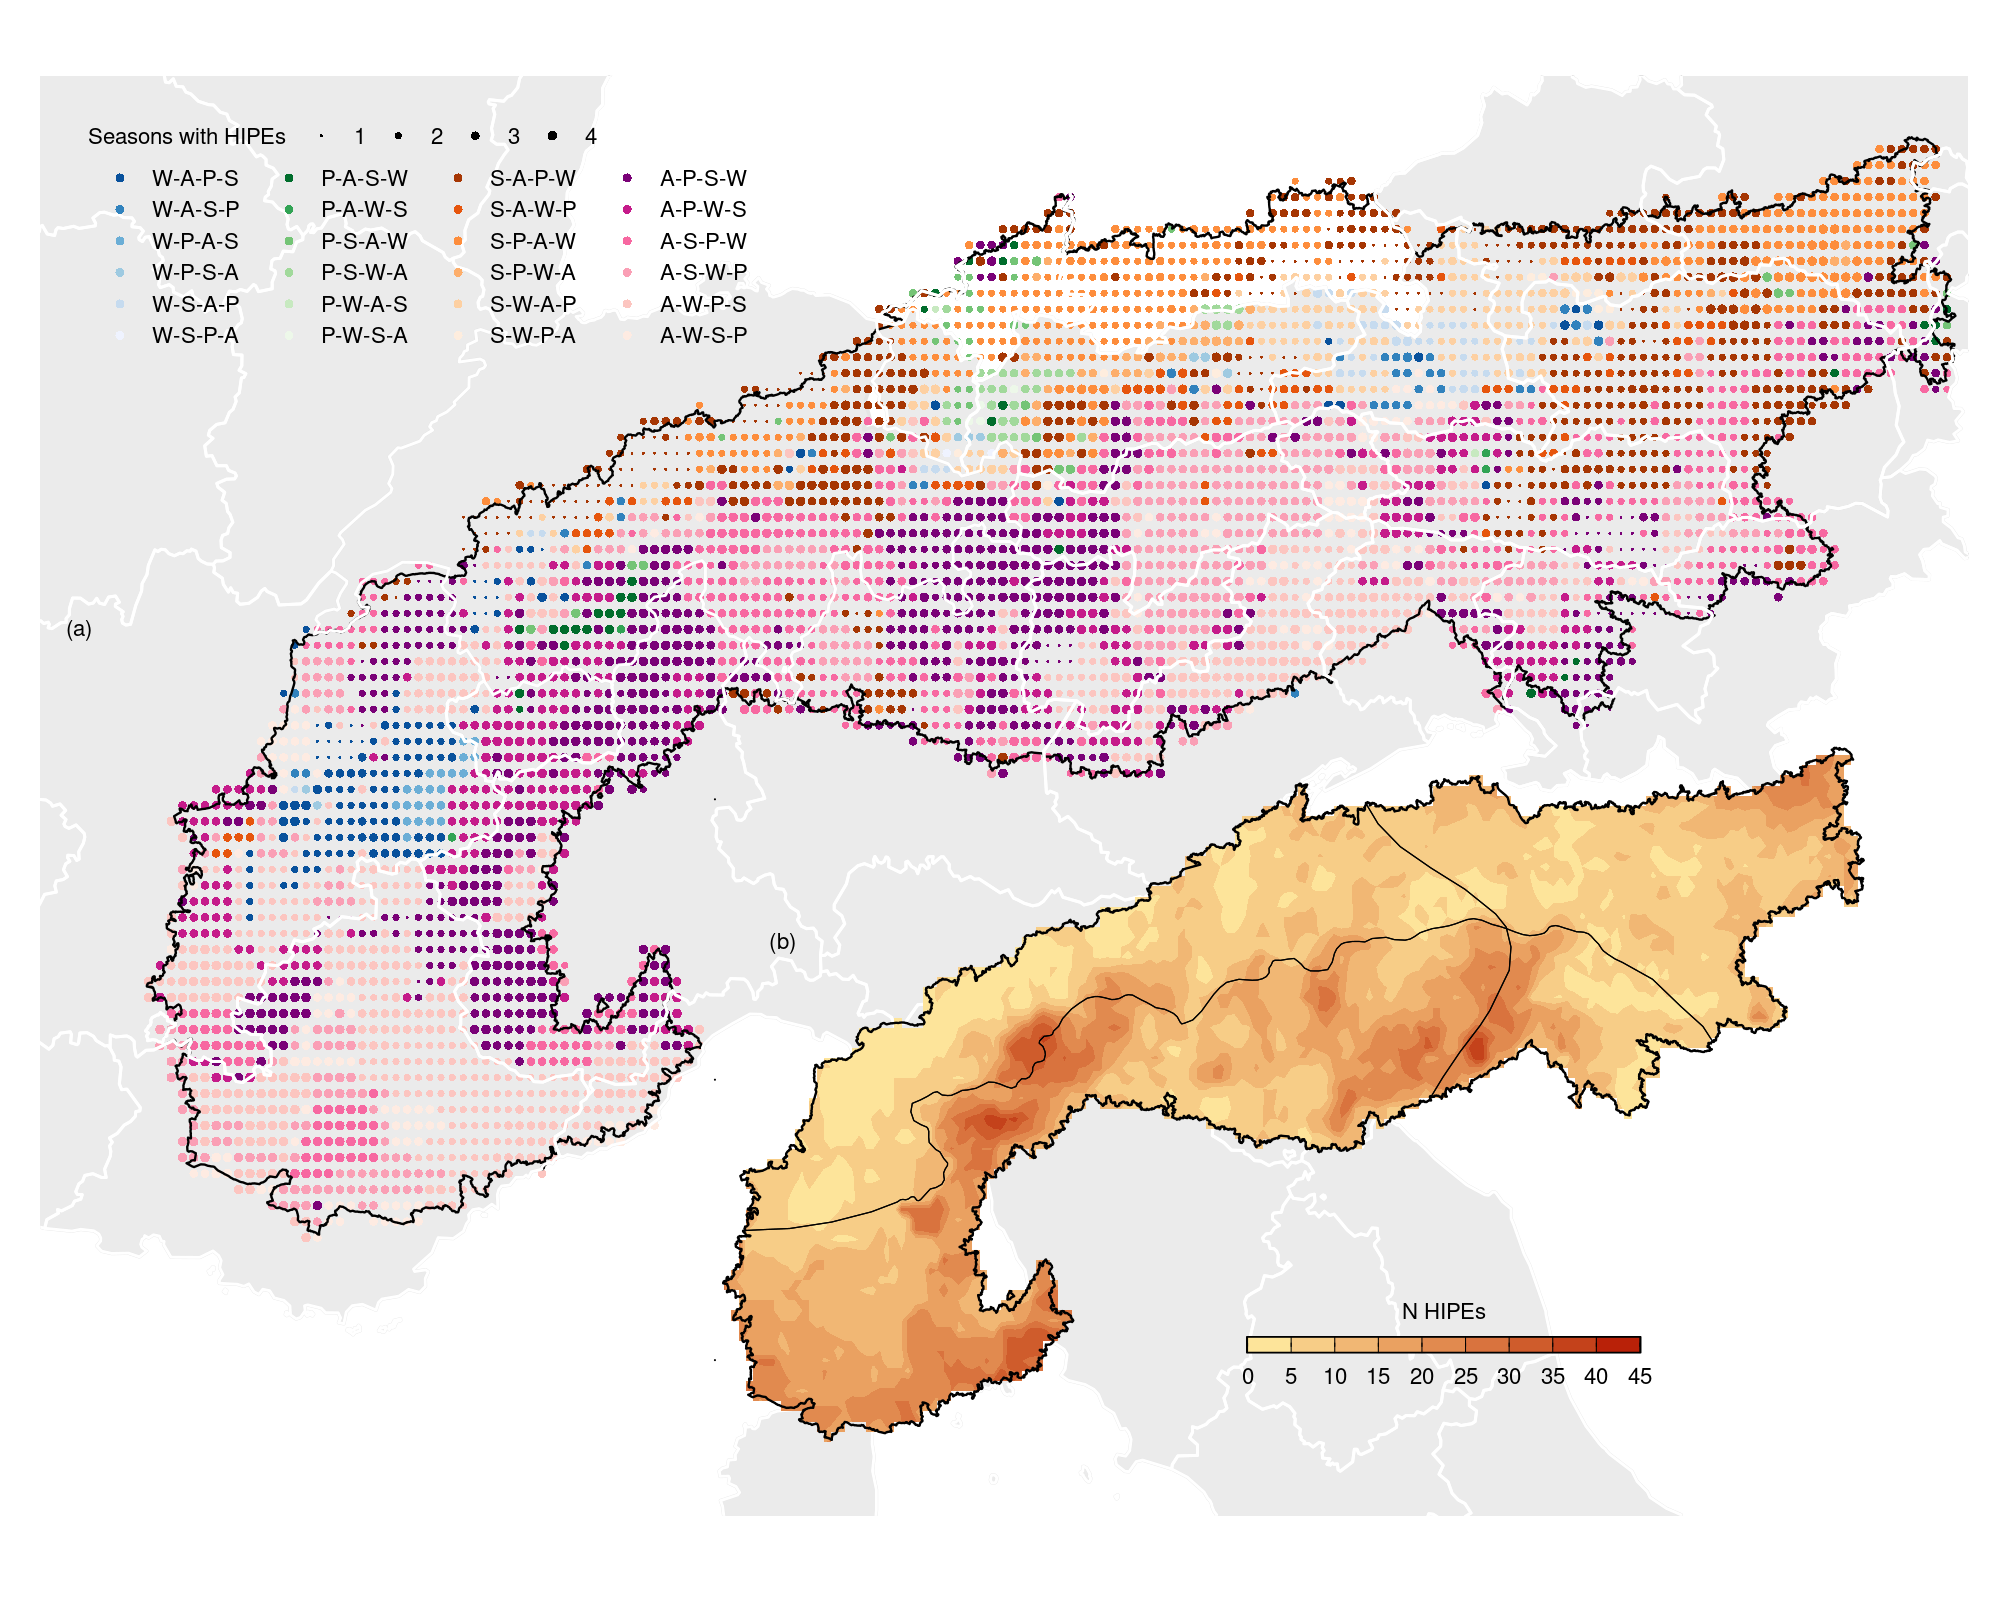

In [14]:
# HIPEs seasonal regimes -------------------------------------------------------------

pcp_regimes <- ACPD_HIPE_grid %>%
  mutate(mo = month(time),
         seasons = case_when(mo %in% c(12,1:2) ~ "W",
                             mo %in% 3:5 ~ "P",
                             mo %in% 6:8 ~ "S",
                             mo %in% 9:11 ~ "A")) %>%
  inner_join(ACPD_HIPE_grid_thr, by = c("lon","lat")) %>%
  group_by(lon,lat) %>%
  mutate(P_H = ifelse(P_H < Thr, NA, P_H)) %>%
  ungroup()%>%
  # arrange(Start_date) %>%
  arrange(time) %>%
  group_by(lat, lon, seasons) %>%
  summarise(
    n_events = sum(P_H>Thr, na.rm =T),
    mean_P_H = ifelse(n_events > 0, mean(P_H, na.rm = TRUE), NA),
    case_season = n_events > 0) %>% 
  group_by(lon,lat) %>%
  mutate(n_case_season_gp = sum(case_season, na.rm = T)) %>%
  arrange(desc(n_events)) %>% 
  ungroup() %>% 
  arrange(lat,lon) %>% 
  group_by(lat,lon) %>%
  mutate(regimes = paste0(seasons, collapse = "-")) %>% 
  ungroup() %>%
  distinct(lon,lat,.keep_all = T) %>%
  mutate(first_letter = substr(regimes, 1, 1),
         order_val = case_when(
           first_letter == "W" ~ 1,
           first_letter == "P" ~ 2,
           first_letter == "S" ~ 3,
           first_letter == "A" ~ 4,
           TRUE ~ 5
         )) %>%
  # Reorder regimes factor based on the ordering variable
  mutate(regimes = fct_reorder(regimes, order_val)) %>%
  select(-first_letter, -order_val)

# Mapping regimes
library(RColorBrewer)
aut_pal <- brewer.pal(n = 6, name = "RdPu") %>% rev()
spr_pal <- brewer.pal(n=6, name = "Greens") %>% rev()
sum_pal <- brewer.pal(n = 6, name = "Oranges") %>% rev()
wint_pal <- brewer.pal(n=6, name = "Blues") %>% rev()
palette <- c(wint_pal,spr_pal,sum_pal,aut_pal)

main <-ggplot() +
  geom_sf(data = borders, fill = "grey92")+
  geom_sf(data = borders, color = "grey90", linewidth = 0.6,fill = "transparent")+
    geom_point(data=filter(pcp_regimes, n_case_season_gp >0), 
               aes(lon,lat, color = regimes,size = n_case_season_gp),
               stroke = 0, alpha = 1,show.legend = T) +
    scale_color_manual(values =  palette,na.value = "transparent", name = "")+
    scale_size_continuous(trans = "sqrt", range = c(0.5,1.6), transform = "log10",
                          breaks = c(1,2,3,4),name = "Seasons with HIPEs") + # Adjust min and max size
    
  geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black")+
  annotate(
    "text", x = -Inf, y = Inf, label = "(a)", # Position at the upper left corner
    hjust = -1.0, vjust = 35, size = 2.8
  ) +
  labs(y = "Annual precipitation")+
  guides(color = guide_legend(ncol = 4)) + # Set legend to 4 columns
    geom_sf(data = borders_w_nuts, fill = "transparent", color = "grey100", linewidth = 0.5)+
    
  coord_sf() +
    scale_x_continuous(limits = c(extent[1]-0.3, extent[2]+0.1), expand = c(0, 0),
                       breaks = seq(6,14,4)) +
    scale_y_continuous(limits = c(extent[3]-1, extent[4]+0.15), expand = c(0, 0),
                       breaks = seq(44,48,2)) +
    theme_4paper +
  theme(
        axis.title.y = element_blank(),
        plot.subtitle = element_blank(),
        panel.border = element_blank(),
        legend.position = "inside",
        legend.direction = "horizontal",
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.position.inside = c(.2,.89),
          legend.spacing.y = unit(0.1, "cm"),  # Reduce vertical spacing between legends
        legend.spacing.x = unit(01, "cm"),  # Reduce hoizontal spacing between legend
          legend.margin = margin(1, 0, 0, 0),  # Adjust margins to move them closer
        legend.key.height = unit(.4, "cm"),
        legend.key.width = unit(.4, "cm"),
        legend.key.spacing.y  = unit(0,"cm"))  # 🔹 Enganxa els quadrets en Y)

main +   inset_element(b, 
                       left = 0.35, bottom = -0.1, 
                       right = .95, top = 0.59)  # Position inset
  